In [ ]:
%matplotlib inline

import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Getting a data

Excluding 5 largest categories

In [ ]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(len(categories))

97


This function is useful for pre-processing the data into an image and input vector.

In [ ]:
def get_image(path,rows,columns):
    img = image.load_img(path, target_size=(rows, columns))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
def preprocessing(rows,columns):
        #Load all the images from root folder
        data = []
        for c, category in enumerate(categories):
            images = [os.path.join(dp, f) for dp, dn, filenames 
                      in os.walk(category) for f in filenames 
                      if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
            for img_path in images:
                img, x = get_image(img_path,rows,columns)
                data.append({'x':np.array(x[0]), 'y':c})

        # count the number of classes
        num_classes = len(categories)
        #Randomize the data order.
        random.shuffle(data)

        #create training / validation / test split (70%, 15%, 15%)
        idx_val = int(train_split * len(data))
        idx_test = int((train_split + val_split) * len(data))
        train = data[:idx_val]
        val = data[idx_val:idx_test]
        test = data[idx_test:]

        #Separate data for labels.
        x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
        x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
        x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

        return x_train,y_train,x_test,y_test,x_val,y_val,data,num_classes


In [ ]:
x_train,y_train,x_test,y_test,x_val,y_val,data,num_classes = preprocessing(244,244)

In [ ]:
x_train.shape

(4346, 244, 244, 3)

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 244, 244, 3)
training labels shape:  (4346, 97)


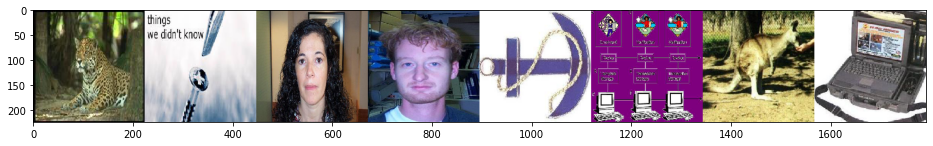

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

**Build a Small CNN from Scratch with two conv layers and two max pooling layers without dropout layers**

In [ ]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (244, 244, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 242, 242, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 119, 119, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
flatten (Flatten)      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_val, y_val))

Epoch 1/5
136/136 [==============================] - 248s 2s/step - loss: 4.0728 - accuracy: 0.1652 - val_loss: 3.3279 - val_accuracy: 0.2836
Epoch 2/5
136/136 [==============================] - 250s 2s/step - loss: 1.4335 - accuracy: 0.6717 - val_loss: 3.0637 - val_accuracy: 0.3577
Epoch 3/5
136/136 [==============================] - 255s 2s/step - loss: 0.1655 - accuracy: 0.9692 - val_loss: 3.7588 - val_accuracy: 0.3759
Epoch 4/5
136/136 [==============================] - 255s 2s/step - loss: 0.0192 - accuracy: 0.9979 - val_loss: 4.1518 - val_accuracy: 0.3910
Epoch 5/5
136/136 [==============================] - 253s 2s/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 4.2968 - val_accuracy: 0.4060


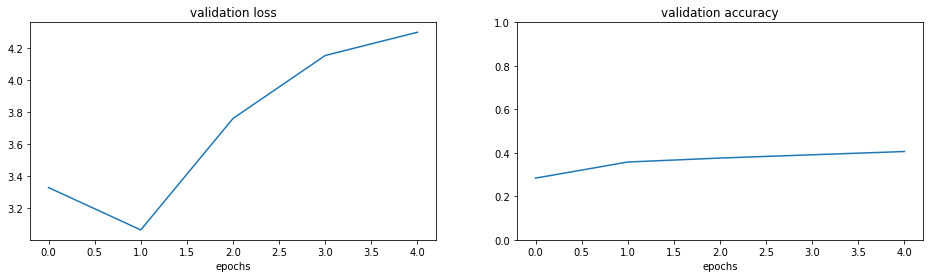

In [ ]:
#Let's plot the validation loss and validation accuracy over time.
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

**Interpretation**:- We can see that the validation loss seems to be increasing at a drastic rate from 1 epochs. However, the validation accuracy seems to be consistent with around 38% accuracy score. This suggest our model becomes overfitting after 1 epochs. 


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 4.3435163497924805
Test accuracy: 0.3776824176311493


Finally, we have got 37.76% accurancy on the test data set. The model is clearly overfitting. Now, we will apply drop out layer in out next version of CNN.

**Build a Small CNN from Scratch with two conv layers and two max pooling layers with dropout layers**

In [ ]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (244, 244, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 242, 242, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 242, 242, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 119, 119, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 119, 119, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxP

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
136/136 [==============================] - 262s 2s/step - loss: 0.4567 - accuracy: 0.8783 - val_loss: 3.2621 - val_accuracy: 0.3759
Epoch 2/10
136/136 [==============================] - 259s 2s/step - loss: 0.2240 - accuracy: 0.9395 - val_loss: 3.4921 - val_accuracy: 0.3813
Epoch 3/10
136/136 [==============================] - 266s 2s/step - loss: 0.1047 - accuracy: 0.9712 - val_loss: 3.7846 - val_accuracy: 0.3727
Epoch 4/10
136/136 [==============================] - 261s 2s/step - loss: 0.0826 - accuracy: 0.9775 - val_loss: 3.9532 - val_accuracy: 0.3813
Epoch 5/10
136/136 [==============================] - 261s 2s/step - loss: 0.0726 - accuracy: 0.9821 - val_loss: 4.3938 - val_accuracy: 0.3759
Epoch 6/10
136/136 [==============================] - 260s 2s/step - loss: 0.0697 - accuracy: 0.9795 - val_loss: 4.2486 - val_accuracy: 0.3620
Epoch 7/10
136/136 [==============================] - 261s 2s/step - loss: 0.0307 - accuracy: 0.9910 - val_loss: 4.1598 - val_accuracy: 0.3974

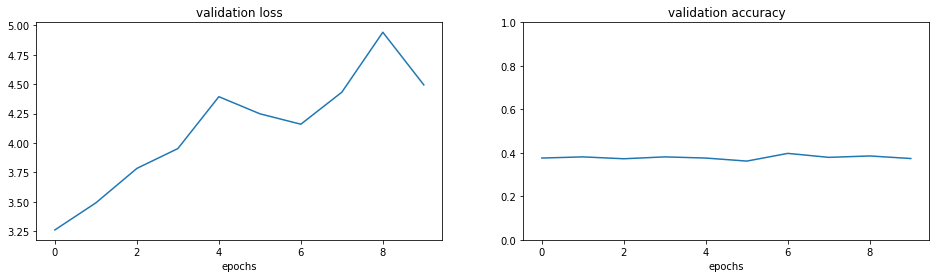

In [ ]:
#Let's plot the validation loss and validation accuracy over time.
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

**Interpretation**:- We can see that the validation loss seems to be increasing at a drastic rate. However, the validation accuracy seems to be slightly declinely after accuracy score reaches to 40%. This suggest our model should use 3 epochs at reach the accuracy level. 

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 4.727561950683594
Test accuracy: 0.3884120285511017


Finally, we have got 38.84% accurancy on the test data set.

**Determine the accuracy on your test data for each version of the network, and discuss any differences.  Are they what you expected?**

As in first version of the network(without drop out layer), we can see overfitting issues after 1 epoch. The accuracy on the test data is 37.36%. On the second version after using drop out with probability 0.5, we can see that we have avoided overfitting issue till 3 epoches. The probability of 0.5 tells us that there is a 50% chance that any neuron can be dropped out or inactivated, which means there is 50% change that the weight of the neuron will be forced to 0. Also, the test accuracy with drop out increases to 38.84%. Therefore, I will be using model with dropout layers added.

**Apply Transfer Learning to a Pretrained Network**


We will be loading InceptionV3, Note that I need to change the shape of the input image to [299x299] instead of [224x224].  **Converting image to 299x299 resulted in RAM crash issue**, therefore, I did a transformation to 150x150 to avoid crash issue.

In [ ]:
x_train,y_train,x_test,y_test,x_val,y_val,data,num_classes = preprocessing(150,150)

Converting to one-hot vectors and checking summary

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 150, 150, 3)
training labels shape:  (4346, 97)


In [ ]:
Incp = keras.applications.InceptionV3(input_shape = x_train.shape[1:],weights='imagenet', include_top=False)
Incp.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

Using InceptionV3 model, we can see there are 93 convolutional layers.The top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 77.89%.

Now, we will re-train the model using new model_new on the new dataset and label.

In [ ]:
# make a reference to VGG's input layer
inp = Incp.input

x = Flatten()(Incp.output)
# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')(x)

# connect our new layer to the second to last layer in VGG, and make a reference to it
#out = new_classification_layer(Incp.layers[-2].output)

# create a new network between inp and out
model_new = Model(inputs = inp, outputs = new_classification_layer)

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
______________________________________________________________________________________

In [ ]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
34/34 [==============================] - 7s 199ms/step - loss: 8.6742 - accuracy: 0.5249 - val_loss: 2.5013 - val_accuracy: 0.7476
Epoch 2/10
34/34 [==============================] - 4s 125ms/step - loss: 0.7512 - accuracy: 0.8921 - val_loss: 1.4141 - val_accuracy: 0.8174
Epoch 3/10
34/34 [==============================] - 4s 126ms/step - loss: 0.2485 - accuracy: 0.9549 - val_loss: 1.4821 - val_accuracy: 0.8120
Epoch 4/10
34/34 [==============================] - 4s 127ms/step - loss: 0.1129 - accuracy: 0.9786 - val_loss: 1.4037 - val_accuracy: 0.8378
Epoch 5/10
34/34 [==============================] - 4s 126ms/step - loss: 0.0498 - accuracy: 0.9906 - val_loss: 1.4004 - val_accuracy: 0.8335
Epoch 6/10
34/34 [==============================] - 4s 127ms/step - loss: 0.0706 - accuracy: 0.9878 - val_loss: 1.4010 - val_accuracy: 0.8271
Epoch 7/10
34/34 [==============================] - 4s 129ms/step - loss: 0.0557 - accuracy: 0.9908 - val_loss: 1.2906 - val_accuracy: 0.8432
Epoch 

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.4510537385940552
Test accuracy: 0.8465664982795715


We have recieved **84.65%** accuracy on the test data with 1.45% test loss using pre-trained model.

**We need to retrain again, unfreezing one extra layer.**

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last two layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-2:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
______________________________________________________________________________________

In [ ]:
history3 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
34/34 [==============================] - 5s 159ms/step - loss: 0.4028 - accuracy: 0.9429 - val_loss: 2.6780 - val_accuracy: 0.7905
Epoch 2/10
34/34 [==============================] - 4s 126ms/step - loss: 0.4628 - accuracy: 0.9459 - val_loss: 2.8981 - val_accuracy: 0.7809
Epoch 3/10
34/34 [==============================] - 4s 127ms/step - loss: 0.2717 - accuracy: 0.9671 - val_loss: 2.7423 - val_accuracy: 0.8002
Epoch 4/10
34/34 [==============================] - 4s 128ms/step - loss: 0.1982 - accuracy: 0.9772 - val_loss: 3.0947 - val_accuracy: 0.8024
Epoch 5/10
34/34 [==============================] - 4s 128ms/step - loss: 0.1673 - accuracy: 0.9761 - val_loss: 3.1787 - val_accuracy: 0.8077
Epoch 6/10
34/34 [==============================] - 4s 129ms/step - loss: 0.1492 - accuracy: 0.9807 - val_loss: 3.4565 - val_accuracy: 0.7884
Epoch 7/10
34/34 [==============================] - 4s 130ms/step - loss: 0.1035 - accuracy: 0.9873 - val_loss: 3.6183 - val_accuracy: 0.8056
Epoch 

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 4.121301651000977
Test accuracy: 0.7972102761268616


We have recieved **79.72%** accuracy on the test data with 4.12% test loss using pre-trained model.

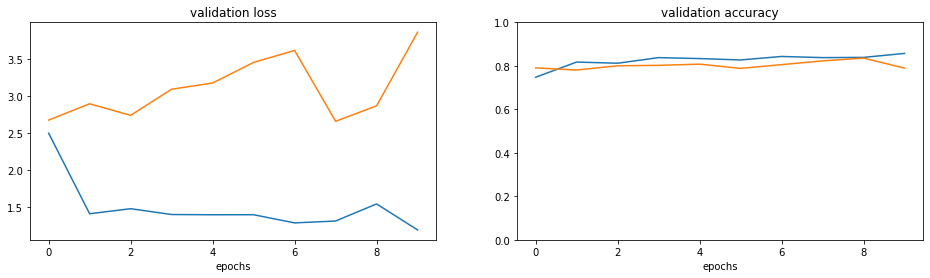

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.plot(history3.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.plot(history3.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

**Compare the accuracies of these two retrained models with each other, and also with the CNNs built from scratch above.**

**Interpretation:-** For the CNN implemeneted from scratch, we see overfitting issue in 1 epochs and with drop out layer in 3 epochs. After using transfer learning model, we see drastic improvement in the model. We can see that the model has accuracy of 83% excluding 1 layer and 79% excluding two layers. We can see that use state of art model, we have achieved good accuracy in the data.

**Apply Data Augmentation to a Pretrained Network**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Generate Images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.08,
                                   zoom_range = 0.08,
                                   horizontal_flip = False,
                                   width_shift_range= 0.02,
                                   height_shift_range= 0.02)
test_datagen = ImageDataGenerator(rescale = 1./255)

# fit parameters from data
training_set = train_datagen.flow(x_train, y_train, batch_size=64)
test_set = test_datagen.flow(x_test, y_test, batch_size=64)

history4 = model_new.fit(training_set,
                         epochs = 20,
                         validation_data = test_set)

Epoch 1/20
68/68 [==============================] - 23s 334ms/step - loss: 1.7720 - accuracy: 0.6072 - val_loss: 2.3554 - val_accuracy: 0.4399
Epoch 2/20
68/68 [==============================] - 22s 330ms/step - loss: 1.7444 - accuracy: 0.6130 - val_loss: 2.3190 - val_accuracy: 0.4421
Epoch 3/20
68/68 [==============================] - 22s 330ms/step - loss: 1.7152 - accuracy: 0.6139 - val_loss: 2.3615 - val_accuracy: 0.4496
Epoch 4/20
68/68 [==============================] - 22s 329ms/step - loss: 1.6824 - accuracy: 0.6298 - val_loss: 2.2807 - val_accuracy: 0.4603
Epoch 5/20
68/68 [==============================] - 22s 327ms/step - loss: 1.6633 - accuracy: 0.6286 - val_loss: 2.3159 - val_accuracy: 0.4539
Epoch 6/20
68/68 [==============================] - 22s 328ms/step - loss: 1.6374 - accuracy: 0.6397 - val_loss: 2.3221 - val_accuracy: 0.4517
Epoch 7/20
68/68 [==============================] - 22s 328ms/step - loss: 1.6166 - accuracy: 0.6415 - val_loss: 2.2505 - val_accuracy: 0.4764


Let's plot the validation loss and validation accuracy over time.

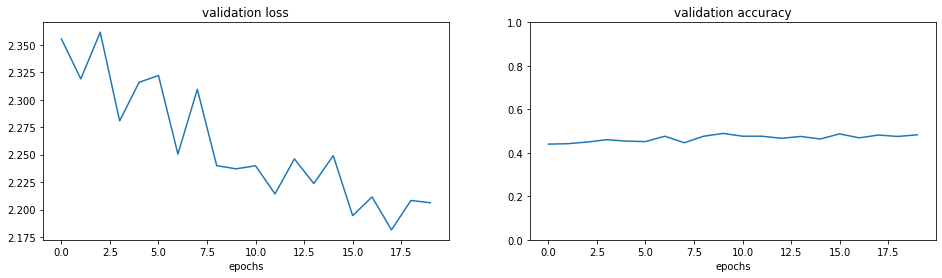

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history4.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history4.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

We can see fluctuation in the validation loss, where as accuracy remains consistent to near about 50%

In [ ]:
loss, accuracy = model_new.evaluate(test_set, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.2062251567840576
Test accuracy: 0.4828326106071472


We can see 49% accuracy in the test data with 2.20 loss after performing augmentation

**What kinds of data augumentation you have chosen and why, and compare the results with those above**

Data augmentation occurs when you create new data based on modification of exisiting data. Since we are using images, so the data augmentation on images would include transformation like, flipping the images either horizontally or vertically, rotating the images, zooming in or out on the images, cropping the images and varying the color on the image.

We have done augumentation using keras.preprocessing.image.ImageDataGenerator and it generally involves rescaling data. Here,

*   Shear range means randomly applying shearing transformation. We have used 0.08 to increase the transformation of a image.
*   Zoom range means randomly zooming inside picture. We have used 0.08 to increase the visibility of a image.
*  Horizental flip means randomly flipping half of the images horizentally. We have set this as false on the assumption that Zoom and shearing will increase the transformation of a image.
*  Width_shift and height_shift are the ranges within which we can randomly translate images vertically or horizentaly. We have set it 0.02 to increse the transformation of images.

Comparing the results:-

CNN from scratch gives about 38% accuracy, transfer leaning state of art model gives about 82% accuracy and augumentating the image gives about 49% accuracy. I would perfer apply transfer learning state of art model to classify images.